In [3]:
import numpy as np
import numba
from plotly import graph_objects as go
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nik/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy



In [4]:
@numba.njit
def ising_step(field, beta=0.4):
    N, M = field.shape
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _ising_update(field, n, m, beta)
    return field


@numba.njit
def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

In [14]:

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def metropolis_mc(equilibrium_steps=0, sample_size=1000,
                  beta=0.4, size=(700, 700), verbose=False):
    if verbose:
        print('sampling...')
    images = [random_spin_field(size[0], size[1])]
    n_steps=equilibrium_steps + sample_size
    for i in tqdm(range(n_steps)):
        images.append(ising_step(images[-1].copy(), beta=beta))
        if i == equilibrium_steps and verbose:
            print('equilibrium is reached')
    return images[equilibrium_steps:]
images = metropolis_mc(beta=1, verbose=True)

sampling...


equilibrium is reached



In [15]:
from PIL import Image

In [16]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [17]:
def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))  # 0 ... 255


display_ising_sequence(images)


interactive(children=(IntSlider(value=500, description='frame', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 1000))>

In [18]:
@numba.njit
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    N = len(config)
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j]\
                 + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.

@numba.njit
def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


In [19]:
Betas = np.exp(np.linspace(np.log(0.12), np.log(0.4), 40))
k_b = 1.3806e-23
sample_size = 500
size = 200
equilibrium_steps = 500

Energies = np.zeros(len(Betas))
Magnetisaisions = np.zeros(len(Betas))
SpecificHeat = np.zeros(len(Betas))
Susceptibility = np.zeros(len(Betas))

n1, n2  = 1.0 / (sample_size * size**2), 1.0 / (sample_size**2 * size**2) 


for idx, cur_beta in tqdm(enumerate(Betas), total=len(Betas)):
    E1 = M1 = E2 = M2 = 0
    
    iT = cur_beta
    iT2 = iT * iT
    
    
    
    for state in metropolis_mc(equilibrium_steps=equilibrium_steps,\
                               sample_size=sample_size, beta=cur_beta, size=(size, size)):
                  
        Ene = calcEnergy(state)     # calculate the energy
        Mag = calcMag(state)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    Energies[idx] = n1 * E1
    Magnetisaisions[idx] = n1 * M1
    SpecificHeat[idx] = (n1 * E2 - n2 * E1 * E1) * iT2
    Susceptibility[idx] = (n1 * M2 - n2 * M1 * M1) * iT


    


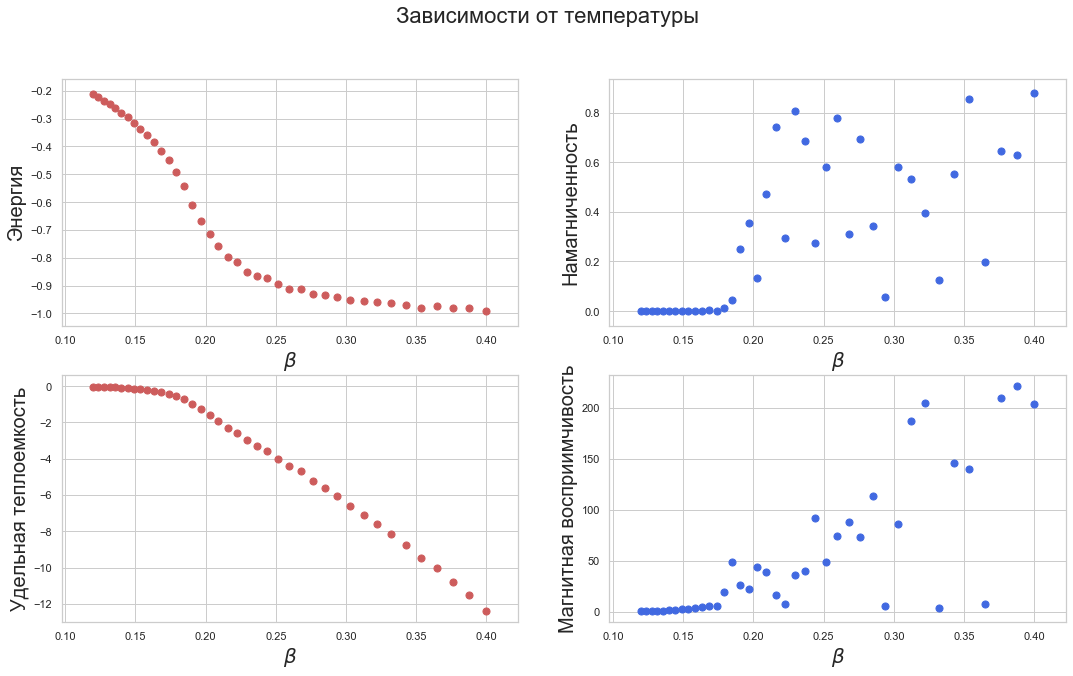

In [24]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(Betas, Energies, s=50, marker='o', color='IndianRed')
plt.xlabel(r"$\beta$", fontsize=20)
plt.ylabel("Энергия", fontsize=20)
plt.axis('tight')

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(Betas, abs(Magnetisaisions), s=50, marker='o', color='RoyalBlue')
plt.xlabel(r"$\beta$", fontsize=20)
plt.ylabel("Намагниченность", fontsize=20)
plt.axis('tight')

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(Betas, SpecificHeat, s=50, marker='o', color='IndianRed')
plt.xlabel(r"$\beta$", fontsize=20);  
plt.ylabel("Удельная теплоемкость", fontsize=20)
plt.axis('tight') 

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(Betas, Susceptibility, s=50, marker='o', color='RoyalBlue')
plt.xlabel(r"$\beta$", fontsize=20); 
plt.ylabel("Магнитная восприимчивость", fontsize=20)
plt.axis('tight')
plt.suptitle('Зависимости от температуры', fontsize=22)
plt.show()